In [1]:
## IMPORTING NECCESSARY LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

In [2]:
## LOADING DATASETS
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
test_ids = test['id']

# EXPLORATORY DATA ANALYSIS

In [3]:
## COPYING TRAINING DATA FOR EDA
df=train.copy()
print(df.shape)
print(df.describe())

print(df.describe(include='object'))
print(df.isnull().sum())
print(df['family'].value_counts())
for i in df.columns:
    print(f"{i} : {df[i].nunique()}")

(3000888, 6)
                 id     store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06  3.000888e+06
mean   1.500444e+06  2.750000e+01  3.577757e+02  2.602770e+00
std    8.662819e+05  1.558579e+01  1.101998e+03  1.221888e+01
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%    7.502218e+05  1.400000e+01  0.000000e+00  0.000000e+00
50%    1.500444e+06  2.750000e+01  1.100000e+01  0.000000e+00
75%    2.250665e+06  4.100000e+01  1.958473e+02  0.000000e+00
max    3.000887e+06  5.400000e+01  1.247170e+05  7.410000e+02
              date      family
count      3000888     3000888
unique        1684          33
top     2013-01-01  AUTOMOTIVE
freq          1782       90936
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
family
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED

# FEATURE ENGINEERING

In [4]:

# COMBINING DATA SETS FOR PREPROCESSING
train['source'] = 'train'
test['source'] = 'test'
full = pd.concat([train, test])

# HANDLING DATETIME FEATURES

full['date'] = pd.to_datetime(full['date'])
full['Year'] = full['date'].dt.year
full['Month'] = full['date'].dt.month
full['Day'] = full['date'].dt.day
full['Weekday'] = full['date'].dt.day_of_week
full.drop(columns='date', inplace=True)

In [5]:
# ENCODING 'family' DUE TO MULITPLE NOMINAL FEATURES
le = LabelEncoder()
full['family'] = le.fit_transform(full['family'])

# REGENERATING ORIGINAL DATASETS
train = full[full['source'] == 'train'].drop(columns='source')
test = full[full['source'] == 'test'].drop(columns=['source', 'sales'])

# VISUALIZATIONS

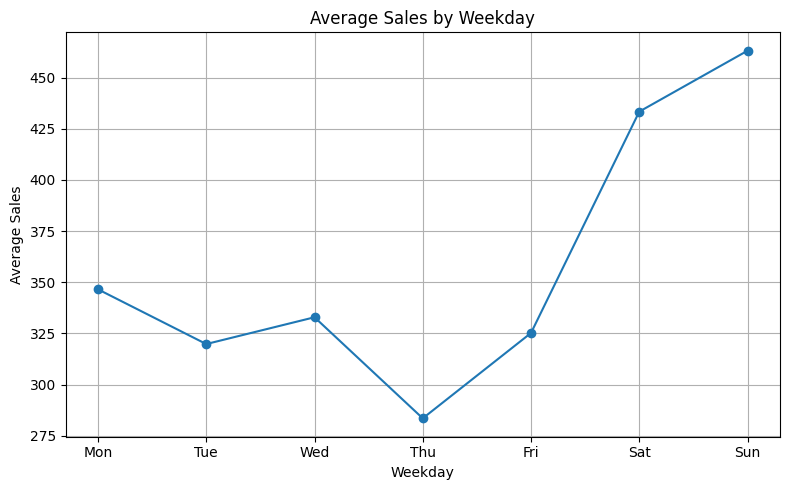

In [6]:
import matplotlib.pyplot as plt
# Group by weekday and calculate average sales
weekday_sales = train.groupby('Weekday')['sales'].mean()
# Plot line chart
## WEEKDAY VS SALES
plt.figure(figsize=(8, 5))
plt.plot(weekday_sales.index, weekday_sales.values, marker='o', linestyle='-')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Average Sales by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

***Weekends show highest average sales while Thursday shows a steep dip***

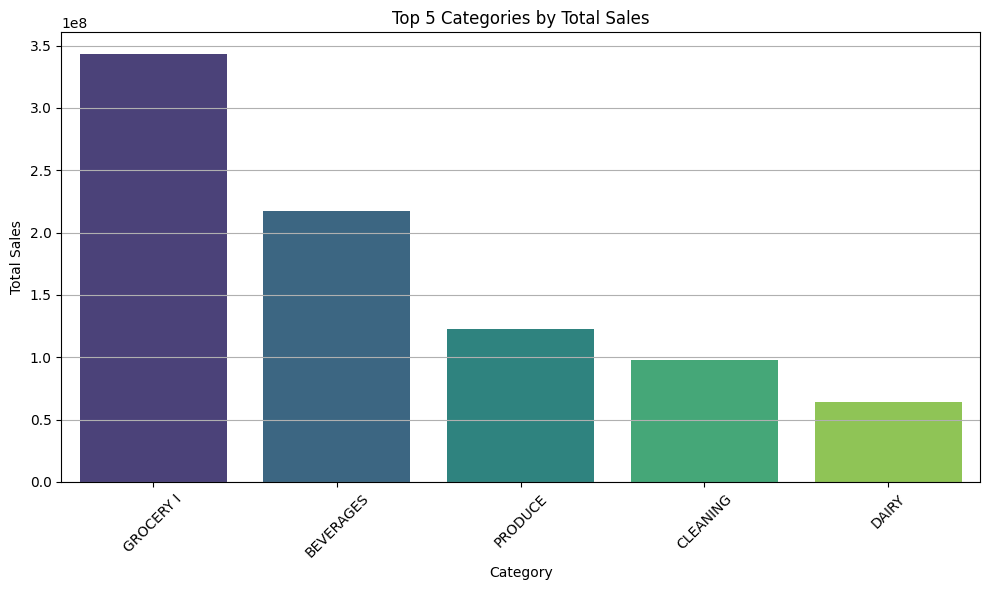

In [7]:
df= pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
category_sales = df.groupby('family')['sales'].sum().sort_values(ascending=False).reset_index()
import seaborn as sns
# Top 5 categories
top_5 = category_sales.head(5)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_5, x='family', y='sales', palette='viridis')
plt.title('Top 5 Categories by Total Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

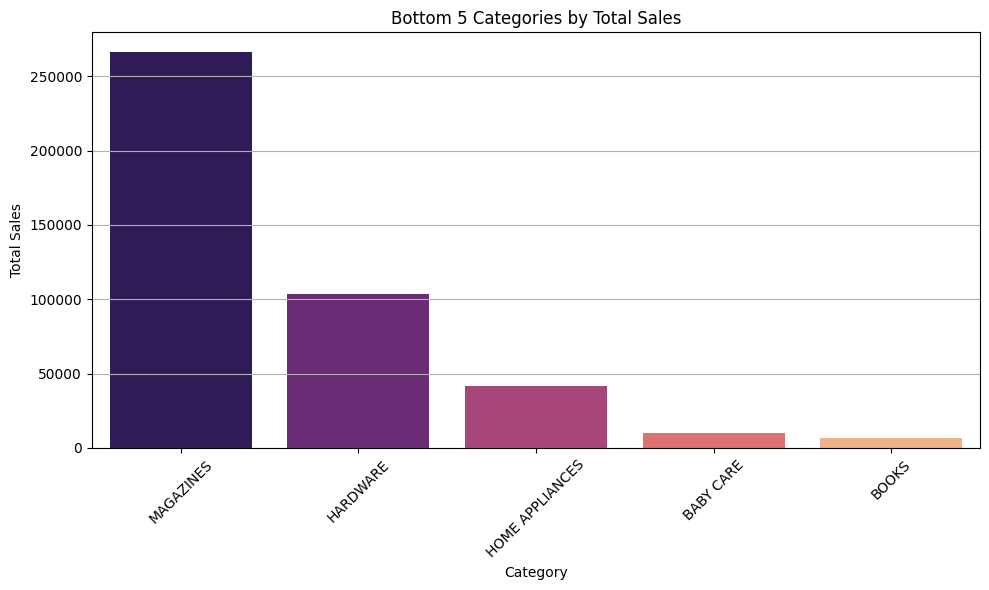

In [8]:
# Bottom 5 categories
bottom_5 = category_sales.tail(5)

plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_5, x='family', y='sales', palette='magma')
plt.title('Bottom 5 Categories by Total Sales')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

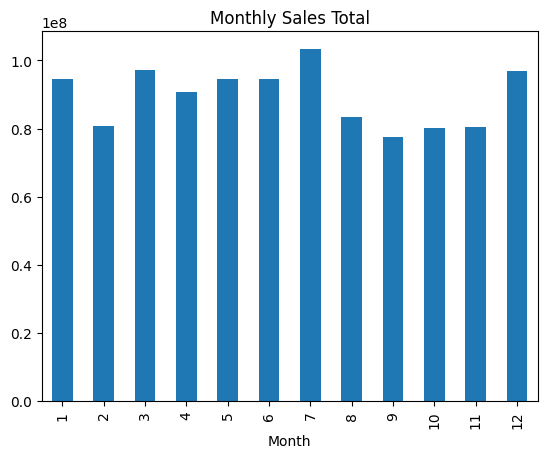

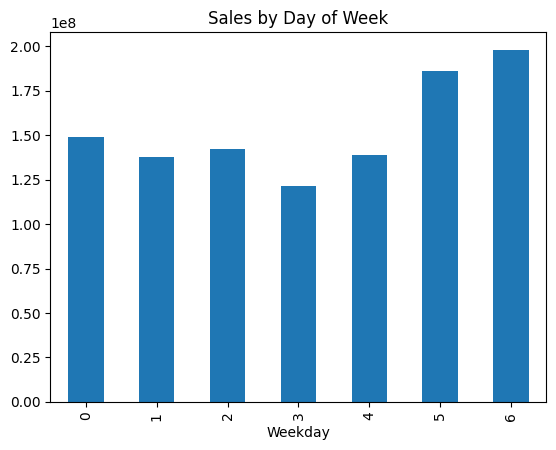

In [9]:
## SEASONALITY CHECK
monthly_sales = train.groupby('Month')['sales'].sum()
dow_sales = train.groupby('Weekday')['sales'].sum()
monthly_sales.plot(kind='bar', title='Monthly Sales Total')
plt.show()
dow_sales.plot(kind='bar', title='Sales by Day of Week')
plt.show()

In [10]:
'''
Q1 = train['sales'].quantile(0.25)
Q3 = train['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = train[(train['sales'] >= lower_bound) & (train['sales'] <= upper_bound)]
'''

## OUTLIER REMOVAL DIDN'T IMPROVISE THE MODEL PERFORMANCE

"\nQ1 = train['sales'].quantile(0.25)\nQ3 = train['sales'].quantile(0.75)\nIQR = Q3 - Q1\n\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\ndf = train[(train['sales'] >= lower_bound) & (train['sales'] <= upper_bound)]\n"

In [11]:
# SEPARATING FEATURES AND TARGET
X = train.drop(columns='sales')
y = train['sales']
X_test = test.copy()

In [12]:
# USING TRAIN TEST SPLIT FOR MODEL VALIDATION
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# PREPROCESSING

In [13]:
## EXTRACTING COLUMNS FOR APPROPRIATE TRANSFORMATION
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'family']

In [14]:
## COLUMNNAR TRANSFORMER FOR APPLING TRANSFORMATIONS
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# HYPERPARAMETER TUNING AND PIPLELINES

In [15]:
## TOP PERFORMING MODEL

'''
model= DecisionTreeRegressor(random_state=42)
param_grid = {
    'tree__max_depth': [5, 10, 15, None],
    'tree__min_samples_split': [2, 5, 10 , 15, 20],
    'tree__min_samples_leaf': [1, 2, 4, 6, 8]
}

# GridSearch with RMSLE scoring
grid = GridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_log_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

'''

'\nmodel= DecisionTreeRegressor(random_state=42)\nparam_grid = {\n    \'tree__max_depth\': [5, 10, 15, None],\n    \'tree__min_samples_split\': [2, 5, 10 , 15, 20],\n    \'tree__min_samples_leaf\': [1, 2, 4, 6, 8]\n}\n\n# GridSearch with RMSLE scoring\ngrid = GridSearchCV(\n    model,\n    param_grid,\n    cv=3,\n    scoring=\'neg_root_mean_squared_log_error\',\n    n_jobs=-1\n)\n\ngrid.fit(X_train, y_train)\nprint("Best Params:", grid.best_params_)\n\n'

In [16]:
# PIPELINE
grid = Pipeline([
    ('prep', preprocessor),
    ('tree', DecisionTreeRegressor(random_state=42,max_depth=None,min_samples_leaf=6,min_samples_split=20))
])

In [17]:
from sklearn.metrics import mean_squared_log_error
import numpy as np
grid.fit(X_train, y_train)
# Validation RMSLE

val_preds = np.maximum(0, grid.predict(X_val))  # avoid negative predictions
val_rmsle = np.sqrt(mean_squared_log_error(y_val.clip(lower=0), val_preds))
print("Validation RMSLE:", val_rmsle)



Validation RMSLE: 0.4753644438940177


In [18]:
# Final training on full data
grid.fit(X, y)

# Predict on test set
final_preds = np.maximum(0, grid.predict(X_test))

In [19]:
# Output submission
pd.DataFrame({'id': test_ids, 'sales': final_preds}).to_csv("submission.csv", index=False)